In [1]:
import json
import time
import numpy as np

In [2]:
from itertools import combinations
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = []

with open('../data/reddit/dataset.json', 'r') as dataset_json:
    dataset = json.loads(dataset_json.read())

#### Filter out deleted

In [5]:
filtered_dataset = list(filter(lambda item: item['author'] != 'deleted', dataset))

print(f'{len(filtered_dataset)} / {len(dataset)}')

32805 / 36873


#### Get month and year from epoch

In [6]:
for record in filtered_dataset:
    
    created_at = time.localtime(record['created_at'])
    
    record['year'] = created_at.tm_year
    record['month'] = created_at.tm_mon

#### Group by year by month by post

In [7]:
breakouts = {}

for record in filtered_dataset:
    a_key = record['year']
    if a_key not in breakouts:
        breakouts[a_key] = {}
        
    b_key = record['month']
    if b_key not in breakouts[a_key]:
        breakouts[a_key][b_key] = defaultdict(list)
        
    by_month = breakouts[a_key][b_key]
        
    c_key = record['post_id']
    breakouts[a_key][b_key][c_key].append(record)

#### Remove all posts with only one author attached

In [8]:
removed_count = 0

a_keys = list(breakouts.keys())
for a_key in a_keys:
    
    b_keys = list(breakouts[a_key].keys())
    for b_key in b_keys:
        
        c_keys = list(breakouts[a_key][b_key].keys())
        for c_key in c_keys:
            
            authors = list(
                map(
                    lambda interaction: interaction['author'],
                    breakouts[a_key][b_key][c_key]
                )
            )
            
            if len(np.unique(authors)) == 1:
                removed_count += 1
                del breakouts[a_key][b_key][c_key]
                
print(f'deleted# {removed_count}')

deleted# 2741


#### Create edgelists by year by month by post

In [9]:
edgelist_breakouts = {}

for year_key in breakouts.keys():
    
    for month_key in breakouts[year_key].keys():
        
        edgelist = []
        for post_key in breakouts[year_key][month_key].keys():
            
            posts = breakouts[year_key][month_key][post_key]
            authors = list(map(lambda interaction: interaction['author'], posts))
            for a, b in combinations(np.unique(authors), 2):
                sort = sorted([a, b], key = lambda a: a.lower())
                edgelist.append(
                    (sort[0], sort[1])
                )
                
        edgelist_breakouts[f'{year_key}-{month_key}'] = edgelist

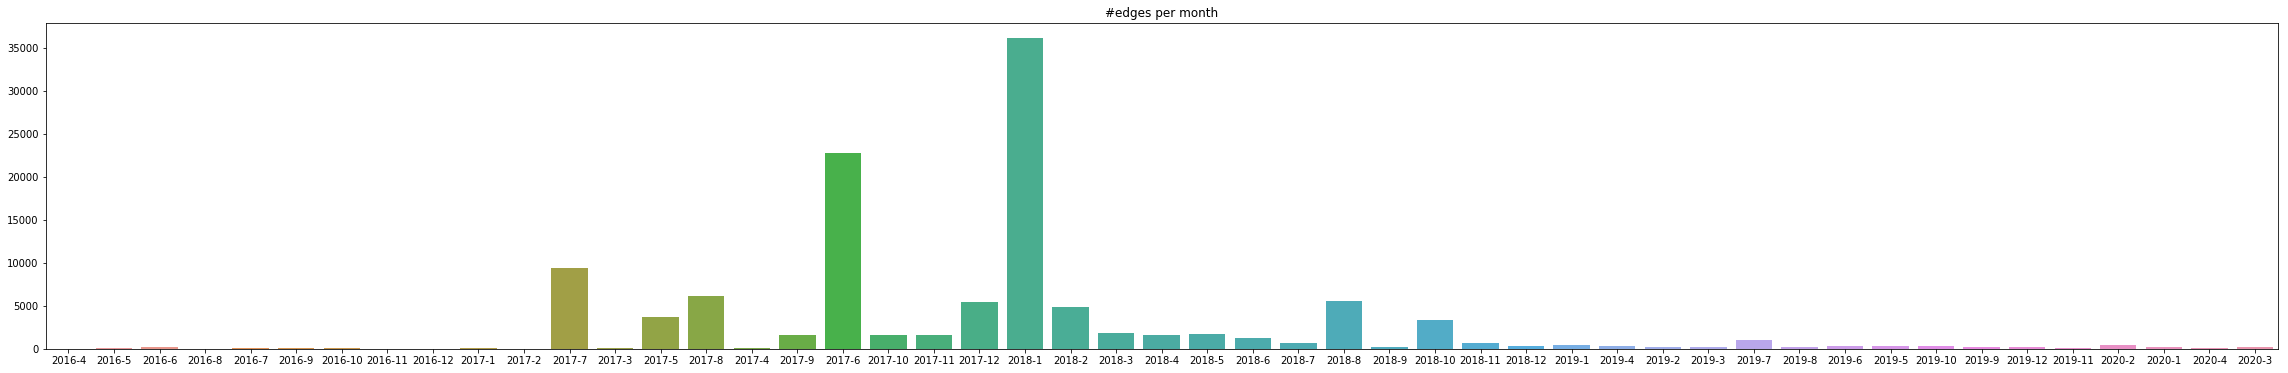

In [10]:
x = []
y = []

for key in edgelist_breakouts.keys():
    x.append(key)
    y.append(len(edgelist_breakouts[key]))

plt.figure(figsize=(40, 6))

plt.title('#edges per month')
sns.barplot(x, y)

In [11]:
import networkx as nx

In [12]:
keys = edgelist_breakouts.keys()

print(f'keys: #{len(keys)}')

keys: #49


In [13]:
def sorter(key):
    parts = key.split('-')
    
    year = parts[0]
    month = parts[1]
    
    if len(month) == 1:
        month = f'0{month}'
        
    return f'{year}-{month}'

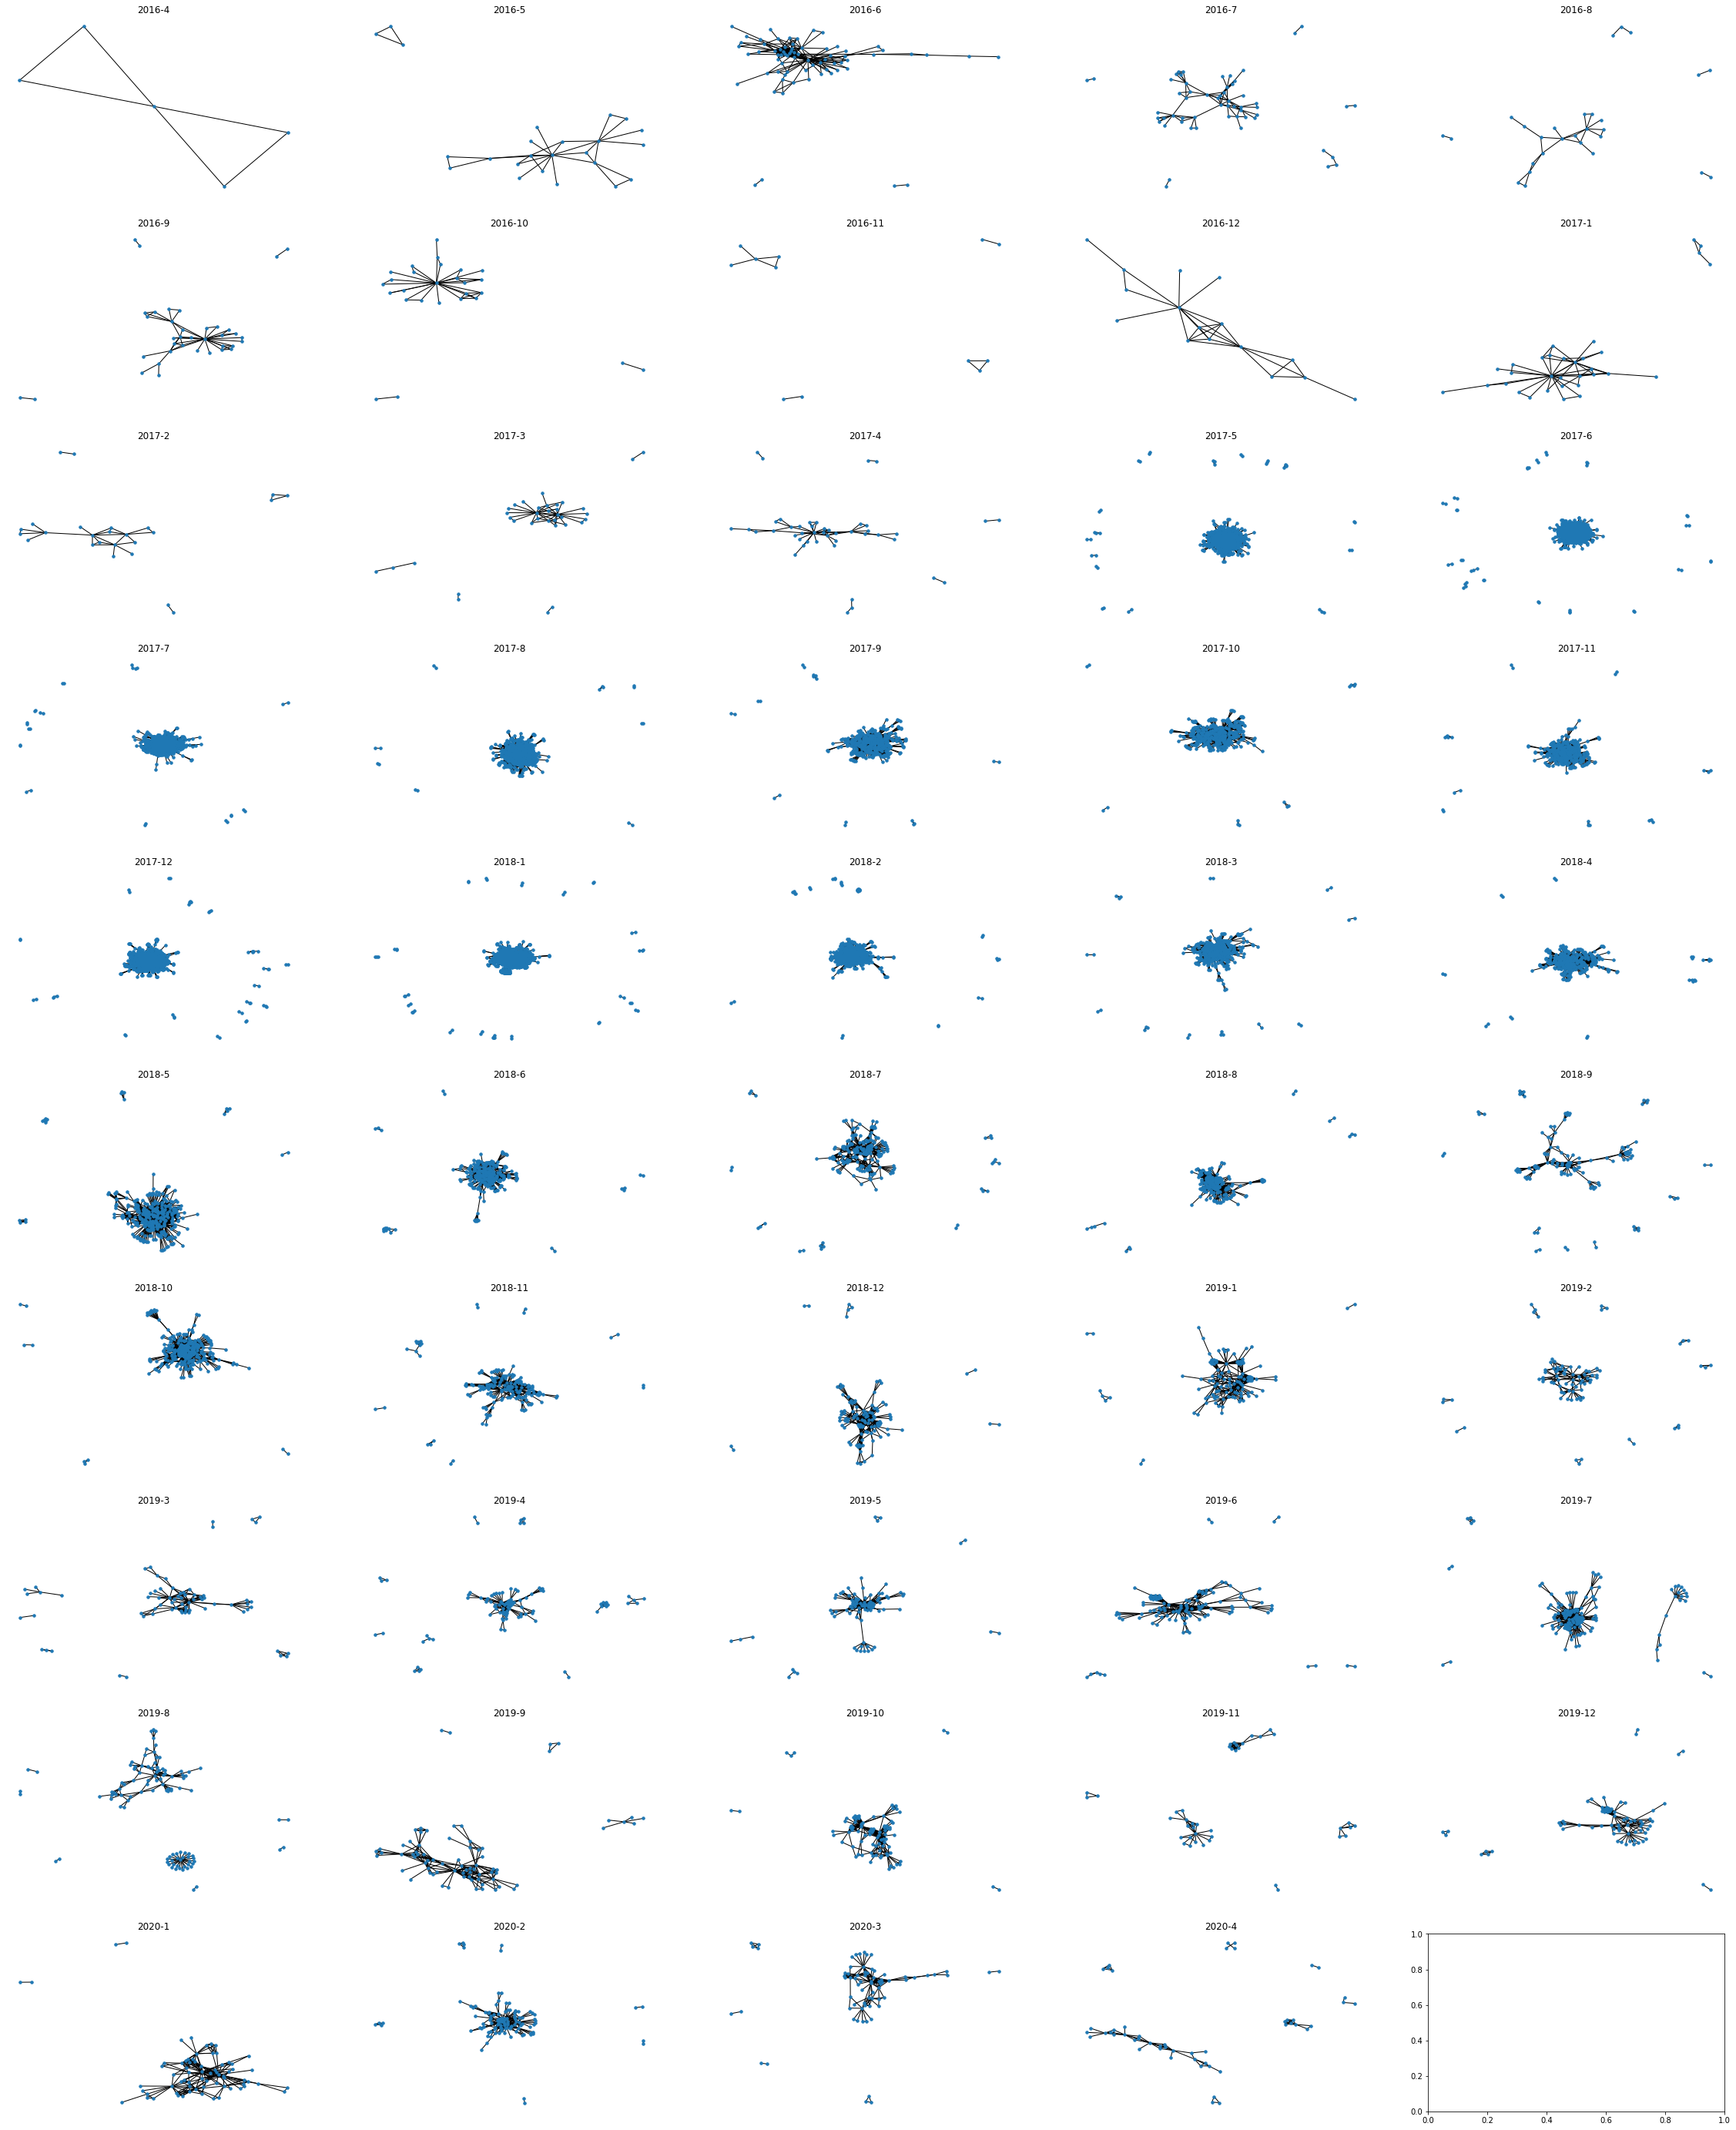

In [14]:
keys = edgelist_breakouts.keys()

plt.figure(figsize=(40, 50))
fig, axs = plt.subplots(10, 5, num = 1)

for i, key in enumerate(sorted(keys, key = sorter)):
    
    G = nx.Graph()
    
    for interaction in edgelist_breakouts[key]:
        n1 = interaction[0]
        n2 = interaction[1]

        if G.has_edge(n1, n2):
            G[n1][n2]['weight'] += 1
        else:
            G.add_edge(n1, n2, weight = 1)
    
    ix = np.unravel_index(i, axs.shape)
    positions = nx.spring_layout(G)
    nx.draw_networkx(G, pos = positions, with_labels = False, node_size = 12, ax=axs[ix])
    
    axs[ix].set_title(key)
    axs[ix].set_axis_off()

In [15]:
## computing centrality metrics for last month,

In [16]:

import pandas as pd

In [17]:
data = {
    '#': dict(G.degree),
    'Degree': nx.degree_centrality(G),
    'Closeness': nx.closeness_centrality(G),
    'Betweenness': nx.betweenness_centrality(G),
    'Pagerank': nx.pagerank(G)
}

df = pd.DataFrame(data)

In [18]:
df.sort_values('Degree', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
mtlynch,9,0.18,0.237193,0.123537,0.047816
DaW_,8,0.16,0.241429,0.123265,0.036598
Rusi12,7,0.14,0.140000,0.008163,0.030327
rezant1,7,0.14,0.185205,0.059048,0.044542
adhkr,5,0.10,0.108889,0.000000,0.020699
Falco98,5,0.10,0.211250,0.000000,0.021177
kizobre,5,0.10,0.108889,0.000000,0.020699
jollyrosso,5,0.10,0.108889,0.000000,0.020699
BlindTiger86,5,0.10,0.108889,0.000000,0.020699


In [19]:
df.sort_values('Closeness', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
DaW_,8,0.16,0.241429,0.123265,0.036598
mtlynch,9,0.18,0.237193,0.123537,0.047816
lpadua,5,0.10,0.211250,0.000000,0.021177
Falco98,5,0.10,0.211250,0.000000,0.021177
Want-A-Cookie,5,0.10,0.211250,0.000000,0.021177
TheRealJoeyTribbiani,5,0.10,0.211250,0.000000,0.021177
aerrejon,4,0.08,0.208000,0.000000,0.017710
MeijeSibbel,4,0.08,0.208000,0.000000,0.017710
sculptex,4,0.08,0.208000,0.000000,0.017710


In [20]:
df.sort_values('Betweenness', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
Taek42,10,0.20,0.265098,0.147755,0.041730
mtlynch,9,0.18,0.237193,0.123537,0.047816
DaW_,8,0.16,0.241429,0.123265,0.036598
yogibjorn,5,0.10,0.190423,0.071837,0.027511
rezant1,7,0.14,0.185205,0.059048,0.044542
lukehmcc,3,0.06,0.182703,0.020408,0.018450
sia-steve,4,0.08,0.146957,0.020408,0.024782
Rusi12,7,0.14,0.140000,0.008163,0.030327
jetarinc,2,0.04,0.040000,0.000816,0.028628
SuperSiayuan,4,0.08,0.177895,0.000272,0.027061


In [21]:
df.sort_values('Pagerank', ascending=False).head(n = 10)

,#,Degree,Closeness,Betweenness,Pagerank
mtlynch,9,0.18,0.237193,0.123537,0.047816
rezant1,7,0.14,0.185205,0.059048,0.044542
Taek42,10,0.20,0.265098,0.147755,0.041730
DaW_,8,0.16,0.241429,0.123265,0.036598
Rusi12,7,0.14,0.140000,0.008163,0.030327
jetarinc,2,0.04,0.040000,0.000816,0.028628
yogibjorn,5,0.10,0.190423,0.071837,0.027511
SuperSiayuan,4,0.08,0.177895,0.000272,0.027061
sia-steve,4,0.08,0.146957,0.020408,0.024782
TheRealJoeyTribbiani,5,0.10,0.211250,0.000000,0.021177
